<a href="https://colab.research.google.com/github/ochaudha/sample/blob/main/FNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import pandas as pd
df  = pd.read_csv("/content/water_train.csv")
print(df.head())
print(df.info())

         ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0  0.483566  0.615597  0.513964     0.777394  0.354601      0.335319   
1  0.639608  0.516021  0.380558     0.390190  0.628308      0.157487   
2  0.370117  0.847246  0.623556     0.992911  0.145461      0.345829   
3  0.545159  0.261747  0.292037     0.535522  0.436155      0.713600   
4  0.610883  0.525235  0.465619     0.475133  0.634338      0.196409   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0        0.367332         0.514102   0.617313           1  
1        0.451506         0.558650   0.834925           0  
2        0.334781         0.402932   0.590146           1  
3        0.667406         0.471880   0.138483           0  
4        0.623423         0.520589   0.755856           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1508 entries, 0 to 1507
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph 

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy

# 1. Data Loading and Preparation
class WaterDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Assuming the last column is the label and the rest are features
        self.features = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
        self.labels = torch.tensor(df.iloc[:, -1].values, dtype=torch.float32).unsqueeze(1) # Ensure labels are shape (N, 1)

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.features)

    def __getitem__(self, idx):
        # Return a single sample (features and label) at the given index
        return self.features[idx], self.labels[idx]

# Create instances of the WaterDataset for training and testing
dataset_train = WaterDataset("/content/water_train.csv")
dataset_test = WaterDataset("/content/water_test.csv") # Assuming a separate test CSV

# Create DataLoaders based on the datasets
dataloader_train = DataLoader(
    dataset_train,
    batch_size=32, # Increased batch size for more efficient training
    shuffle=True, # Shuffle training data for better generalization
)

dataloader_test = DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False, # No need to shuffle test data
)

# 2. Model Definition (Fully Connected Neural Network)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the three linear layers
        self.fc1 = nn.Linear(9, 16) # Input layer with 9 features
        self.fc2 = nn.Linear(16, 8) # Hidden layer with 16 neurons
        self.fc3 = nn.Linear(8, 1)  # Output layer with 1 neuron for binary classification

    def forward(self, x):
        # Pass x through linear layers adding activations
        x = torch.relu(self.fc1(x)) # Apply ReLU activation to the first hidden layer output
        x = torch.relu(self.fc2(x)) # Apply ReLU activation to the second hidden layer output
        x = torch.sigmoid(self.fc3(x)) # Apply sigmoid activation to the output layer for binary classification probabilities
        return x

# 3. Training Setup
net = Net()

# Define a loss function suitable for binary classification
criterion = nn.BCELoss() # Binary Cross-Entropy Loss

# Define the Adam optimizer for more robust training than simple SGD
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training function
def train_model(net, dataloader_train, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        net.train() # Set the model to training mode
        running_loss = 0.0
        for inputs, labels in dataloader_train:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader_train):.4f}")

# Train the model
train_model(
    net=net,
    dataloader_train=dataloader_train,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
)

# 4. Evaluation
# Set up binary accuracy metric
acc = Accuracy(task="binary") # Initialize the Accuracy metric for binary classification

net.eval() # Set the model to evaluation mode (disables operations like dropout)
with torch.no_grad(): # Disable gradient calculations to save memory and computation
    for features, labels in dataloader_test: # Iterate over the test data batches
        # Get predicted probabilities for test data batch
        outputs = net(features) # Pass test features through the trained network to get output probabilities
        # Convert probabilities to binary predictions (0 or 1)
        preds = (outputs >= 0.5).float() # Apply a threshold of 0.5 to convert probabilities to binary predictions
        acc(preds, labels) # Update the Accuracy metric with the predictions and true labels

# Compute total test accuracy
test_accuracy = acc.compute() # Calculate the overall accuracy from the accumulated values
print(f"Test accuracy: {test_accuracy}") # Print the computed test accuracy


Epoch 1/10, Loss: 0.7187
Epoch 2/10, Loss: 0.6961
Epoch 3/10, Loss: 0.6797
Epoch 4/10, Loss: 0.6758
Epoch 5/10, Loss: 0.6769
Epoch 6/10, Loss: 0.6753
Epoch 7/10, Loss: 0.6748
Epoch 8/10, Loss: 0.6762
Epoch 9/10, Loss: 0.6768
Epoch 10/10, Loss: 0.6748
Test accuracy: 0.5904572606086731


explain overfitting and underfitting. bias and variance. explain in detail
In machine learning, building a model that performs well isn't just about getting high accuracy on the data you train it on. A truly effective model needs to generalize, meaning it should make accurate predictions on new, unseen data as well.
Two fundamental issues that affect a model's ability to generalize are overfitting and underfitting, which are closely related to the concepts of bias and variance.
1. **Overfitting**
What it is: Overfitting occurs when a model learns the training data too well, including the noise and random fluctuations present in the training set. This is like a student who memorizes every answer in a practice test but doesn't understand the concepts, so they struggle on a real test.
*Why it happens*:
*Complex Models*: Using models with too many parameters or layers relative to the amount of training data.
*Insufficient Data*: A small training dataset may not be representative enough of the true data distribution, leading the model to learn noise.
*Noisy Data*: The presence of outliers or errors in the training data can cause the model to incorrectly learn them as patterns.
*Overtraining*: Training the model for too long can lead to it memorizing the training data.
*Consequences*:
*Poor Generalization*: Overfitted models perform poorly on new, unseen data because they haven't learned the true underlying patterns.
High Variance: The model's predictions are highly sensitive to the specific training data, meaning small changes in the input can lead to large changes in the output.
*How to detect*:
High training accuracy, low test accuracy: The model does well on the training data but struggles on the test data.
Learning curves: Training loss decreases while validation loss increases, indicating the model is memorizing the training data.
*How to prevent/mitigate*:
*Regularization*: Techniques like L1 and L2 regularization penalize complex models, encouraging them to be simpler.
*Dropout*: Randomly deactivating neurons during training in neural networks.
*Cross-validation*: Splitting the data into multiple folds for training and testing to get a more reliable estimate of generalization performance.
*Early stopping*: Halting the training process when performance on a validation set starts to decline.
Increase training data: Providing more diverse data helps the model learn general patterns.
*Simplify the model*: Using a less complex model architecture.
2. **Underfitting**
*What it is*: Underfitting occurs when a model is too simple to capture the underlying patterns and relationships in the data. This is like a student who doesn't study enough and performs poorly on both practice tests and the real test.
*Why it happens*:
Simple Models: Using models that lack the complexity to capture the data's nuances.
Insufficient Features: Not including enough relevant features to adequately represent the problem.
*Lack of Training Data*: Limited training data can prevent the model from learning the underlying patterns.
*Excessive Regularization*: Too much regularization can overly constrain the model's flexibility, leading to underfitting.
**Consequences**:
Poor Performance: Underfitted models perform poorly on both the training and test sets.
High Bias: The model makes strong assumptions about the data, leading to systematic errors.
How to detect:
High errors on both training and test data: The model performs poorly across the board.
Learning curves: Training and validation errors are consistently high and may converge.
*How to prevent/mitigate*:
Increase model complexity: Use a more sophisticated model or a deeper neural network.
Add more features: Introduce additional features that provide more information to the model.
Reduce regularization: Lessen the constraints imposed by regularization techniques.
Increase training time/epochs: Allow the model more time to learn from the data.
3. **Bias and Variance**
Bias and variance are two main sources of error that affect a model's ability to generalize.
Bias: This error comes from simplistic assumptions in the learning algorithm. High bias means the model is too simple, leading to underfitting and poor performance. Low bias means the model can fit the training data well, but doesn't guarantee good performance on new data.
Variance: This refers to how sensitive the model is to changes in the training data. High variance indicates an overly flexible model that learns the training data too closely, including noise, resulting in overfitting and poor generalization. Low variance means the model is more stable across different datasets, but could still underfit if bias is high.  
4. **The Bias-Variance Tradeoff**
Bias and variance have an inverse relationship. Increasing model complexity reduces bias but increases variance, while simplifying the model reduces variance but increases bias. The goal is to find a balance to minimize the total error. This involves selecting an appropriate model complexity and using techniques like regularization, cross-validation, and early stopping.
In summary:
*Underfitting (high bias, low variance)* occurs when a model is too simple.
*Overfitting (low bias, high variance)* happens when a model is too complex and fits the training data too well, failing to generalize.
The bias-variance tradeoff aims to find the right model complexity to avoid both underfitting and overfitting.
Managing this tradeoff is key to building models that perform well on unseen data.




explain vanishing gradient
The vanishing gradient problem is a significant challenge encountered during the training of deep neural networks, particularly when using activation functions like sigmoid or tanh.
Here's a breakdown of what it is and why it happens:
1. **The Problem**:
In deep neural networks, during the training process, an algorithm called backpropagation is used to adjust the network's weights and biases to minimize the difference between predicted outputs and actual target values (loss).
Backpropagation relies on calculating gradients, which essentially tell us how much to change each weight to reduce the error.
The vanishing gradient problem occurs when these gradients become extremely small, or "vanish," as they are propagated backward through the layers, especially in deep networks with many hidden layers.
When gradients become very small, the weights in the earlier layers of the network receive negligible updates, effectively halting the learning process in those layers.
2. **Why it Happens (Causes)**:
Activation Functions: Certain activation functions, such as the sigmoid and hyperbolic tangent (tanh) functions, are prone to this problem.
These functions compress input values into a limited range (e.g., sigmoid maps values to between 0 and 1).
Their derivatives become very small, approaching zero, for inputs that are far from zero.
During backpropagation, these small derivatives are multiplied through multiple layers, leading to exponentially smaller gradients.
Deep Network Architectures: In deep networks, the chain rule of calculus used in backpropagation means that gradients are multiplied through many layers.
If the gradients in earlier layers are already small, this repeated multiplication through multiple layers can cause them to vanish entirely by the time they reach the layers closest to the input.
Weight Initialization: Poor weight initialization can also contribute to the vanishing gradient problem.
If initial weights are too small, gradients can become very small during backpropagation, making it difficult to update the weights effectively.
3. **Consequences**:
Slow or Stalled Learning: The network may take an excessive amount of time to converge, or it might not converge at all, failing to learn effectively.
Sub-optimal Accuracy: Layers far from the output layer, especially those close to the input, don't learn well, leading to poor feature representation and overall lower accuracy.
Difficulty with Deep Networks: The vanishing gradient problem limits the ability to train very deep neural networks, as the problem worsens with increasing depth.
4. **Solutions**:
Fortunately, researchers have developed several techniques to address the vanishing gradient problem:
**ReLU (Rectified Linear Unit) Activation Function**: This activation function and its variants (like Leaky ReLU) have largely replaced sigmoid and tanh in many modern neural networks.
ReLU outputs the input directly if it's positive and zero otherwise, avoiding saturation for positive inputs and maintaining a constant positive gradient.
**Batch Normalization**: This technique normalizes the inputs to each layer, helping to stabilize training and maintain a reasonable range of gradients.
**Residual Networks (ResNets)**: These architectures introduce "skip connections" that allow gradients to flow more directly through the network, mitigating vanishing gradients and enabling the training of very deep models.
Proper Weight Initialization: Techniques like He initialization help to initialize weights in a way that prevents gradients from vanishing or exploding during backpropagation.
**Gradient Clipping**: This technique sets a maximum threshold for gradients, preventing them from becoming too small or too large.
By implementing these solutions, you can effectively mitigate the vanishing gradient problem and enable the successful training of deep neural networks.
AI responses may include mistakes. Learn more


**what is drop layer**
A dropout layer is a regularization technique used in neural networks to prevent overfitting.
During training, a dropout layer randomly deactivates a fraction of neurons in a layer, setting their outputs to zero. This fraction is determined by the dropout rate, typically between 0.2 and 0.5. This process trains various "thinned" networks with shared weights, creating an ensemble effect that helps the model generalize. Dropout also prevents neurons from becoming too dependent on each other, encouraging them to learn more independent features.
During inference, all neurons are active, and their outputs are scaled down by the dropout rate to maintain consistency with the training phase.
Why is it needed?
Dropout is used to combat overfitting, a common issue in deep networks where the model learns the training data too specifically, leading to poor performance on new data. By forcing the network to learn more distributed representations, dropout improves its ability to generalize and perform better on unseen examples.
In essence, a dropout layer is a regularization technique that enhances the generalization of neural networks by randomly deactivating neurons during training. This strategy prevents overfitting by promoting independent learning and creating an ensemble of subnetworks within the main network.




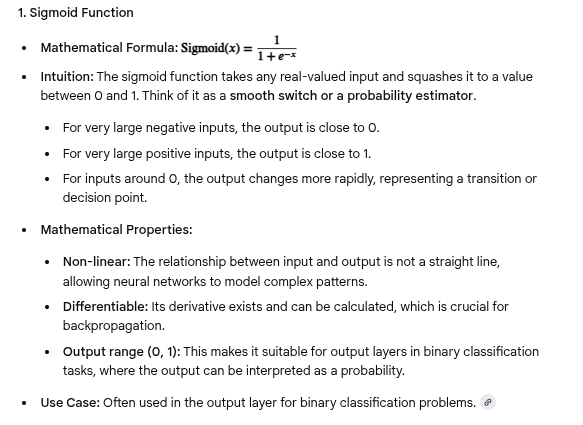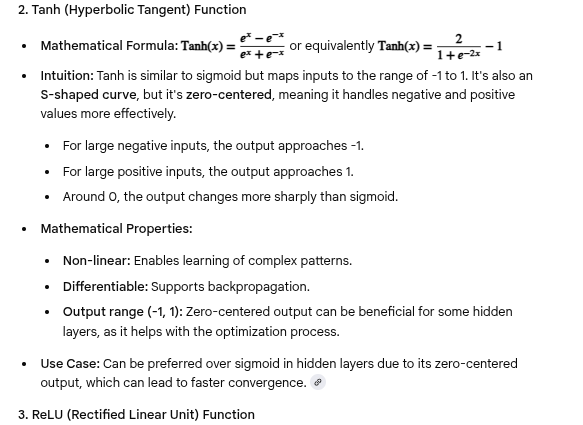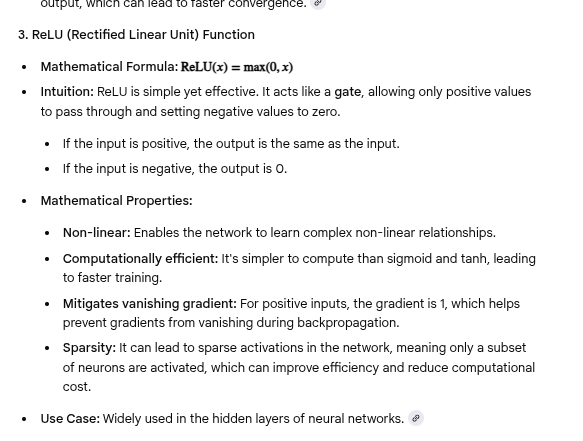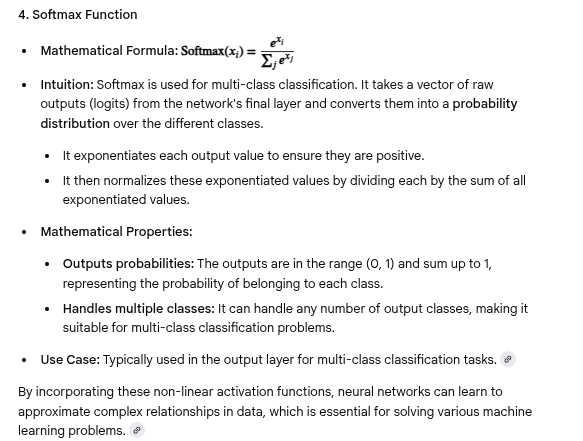